In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import random
import math

In [2]:
def total_variation(b_input, R_P_Lambda, R, A):

    MAXIMUM_ITERATIONS = 1000
    ABSOLUTE_TOLERANCE = 1e-4
    RELATIVE_TOLERANCE = 1e-2
    n = len(b_input)

    if np.ndim(b_input) == 1:
        b_input = b_input[:, None]

    e = np.ones(n)

    D = scipy.sparse.spdiags(np.vstack((e, -e)), (0, 1), n, n)
    DtD = D.T @ D

    I = scipy.sparse.eye(n, format='csc')

    x = np.zeros((n, 1))
    z = x.copy()
    u = x.copy()

    history = {'OBJ_VAL': [],
               'R_NORM': [],
               'S_NORM': [],
               'EPS_PRIM': [],
               'EPS_DUAL': []}
    for k in range(MAX_ITER):

        x = scipy.sparse.linalg.spsolve(
            (I + R * DtD), (b_input + R * D.T.dot(z - u)))

        z_ = z
        Ax_hat = A * D @ x + (1 - A) * z_
        z = shrinkage(Ax_hat + u, R_P_Lambda / R)

        u = u + Ax_hat - z

        objval = TV_denoising_objective(b_input, R_P_Lambda, x, z)

        r_norm = np.linalg.norm(D @ x - z)
        s_norm = np.linalg.norm(-R * D.T @ (z - z_))

        eps_prim = np.sqrt(n) * ABSTOL + RELTOL * max(np.linalg.norm(D @ x),
                                                      np.linalg.norm(-z))
        eps_dual = np.sqrt(n) * ABSTOL + RELTOL * np.linalg.norm(R * D.T @ u)

        history['OBJ_VAL'].append(objval)
        history['R_NORM'].append(r_norm)
        history['S_NORM'].append(s_norm)
        history['EPS_PRIM'].append(eps_prim)
        history['EPS_DUAL'].append(eps_dual)

        if r_norm < eps_prim and s_norm < eps_dual:
            break

    return history, x


In [3]:
def TV_denoising_objective(b_input, R_P_Lambda, x, z):
    """TV denoising objective calculation"""
    return 0.5 * np.linalg.norm(x - b_input)**2 + R_P_Lambda * np.linalg.norm(z)


In [4]:
def shrinkage(a, kappa):
    """Soft-thresholding of `a` with threshold `kappa`"""
    return np.clip(a-kappa, a_min=0, a_max=None) - np.clip(-a-kappa, a_min=0, a_max=None)

In [5]:
n = 100
x0 = np.ones(n)
for j in range(1, 4):
    idx = random.randint(1, n)
    k = random.randint(1, 10)
    x0[(np.vstack((math.ceil(idx / 2), idx)))] = k * \
        x0[(np.vstack((math.ceil(idx / 2), idx)))]


b_input = x0 + np.random.randn(n, 1)
R_P_Lambda = 5
e = np.ones(n)
D = scipy.sparse.spdiags(np.vstack((e, -e)), (0, 1), n, n)

his, x = total_variation(b_input, R_P_Lambda, 1.0, 1.0)

for key, value in his.items():
    str(value)
    print(key, ': \n')
    print(value[:72:],"\n")


OBJ_VAL : 

[1821.3484891663202, 3000.5849439220074, 3451.4930393941554, 3658.417119393373, 3775.0133577473403, 3852.044178066963, 3905.901145479175, 3946.476752794925, 3979.4755221140867, 4007.200172596088, 4031.0444424385114, 4051.910311352133, 4070.414726116401, 4087.001215091265, 4102.002125206183, 4115.67458803379, 4128.2224623708735, 4139.752887130057, 4150.393452715819, 4160.290037962794, 4169.460446843211, 4178.087151266202, 4186.246221888866, 4193.999360248011, 4201.398085122401, 4208.486003418955, 4215.300330349132, 4221.873023833051, 4228.231666409681, 4234.400162919485, 4240.399299577552, 4246.247197830803, 4251.9596876798105, 4257.550618595313, 4263.032121328032, 4268.414830428867, 4273.708619543966, 4278.812053720268, 4283.551078891837, 4288.017746361032, 4292.479206364658, 4296.952141760348, 4301.433832536189, 4305.915390164554, 4310.387799626086, 4314.896412767931, 4311.736744367698, 4308.326450548265, 4305.576198378777, 4303.598325236671, 4302.311336891124, 4301.575825

Text(0, 0.5, 'f(x^k) + g(z^k)')

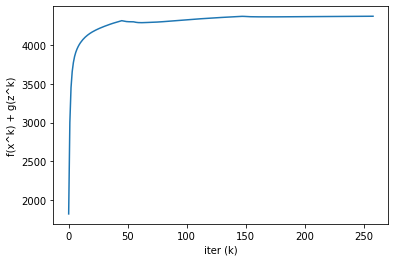

In [6]:
plt.plot(his['OBJ_VAL'])
plt.show
plt.xlabel("iter (k)")
plt.ylabel("f(x^k) + g(z^k)")

<function matplotlib.pyplot.show(*args, **kw)>

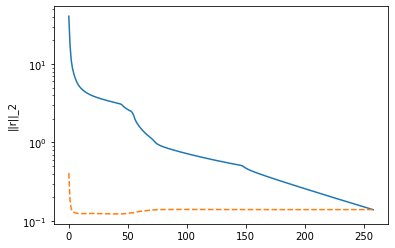

In [7]:
plt.semilogy(np.clip(his['R_NORM'], a_min=1e-8, a_max=None))
plt.semilogy(his['EPS_PRIM'],linestyle = '--')
plt.ylabel('||r||_2')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

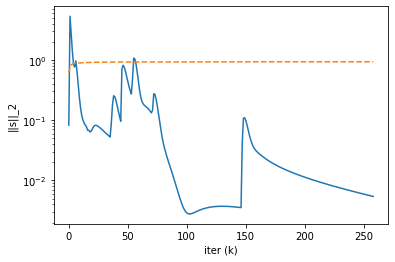

In [8]:
plt.semilogy(np.clip(his['S_NORM'], a_min=1e-8, a_max=None))
plt.semilogy(his['EPS_DUAL'], linestyle = '--')
plt.xlabel("iter (k)")
plt.ylabel('||s||_2')
plt.show